
**Tutorial # 1 - Introduction**

Goals:

1.   Train, validate, and test a segmentation network using keras
2.   Implement a multi-modality version and test its performance
3.   Test effect of hyperparameters (batch size, patch size, epochs, n kernels)
4.   Test effect of intensity standardisation
5.   Test effect of skip connections (segnet -> unet)
6.   Get used to keras

**Import libraries**

In [20]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

**Define parameters**

In [107]:
# dataset parameters
FNAME_PATTERN = 'C:\\Users\\LENOVO\\Documents\\Third_Semester\\CAD\\Seminar\\iSeg2019-Training/subject-{}-{}.hdr'
N_VOLUMES = 10
IMAGE_SIZE = (144, 192, 256)

# network parameters
N_CLASSES = 4             #4 tissues, GM,WM, CSF, background
N_INPUT_CHANNELS = 2
PATCH_SIZE = (32, 32)    # depends on the type of segmentation problem, if it's smaller area use smaller patch size
PATCH_STRIDE = (64, 64)  # bigger patches work better

# training, validation, test parameters
TRAINING_VOLUMES = [0, 1, 2, 3, 4, 5, 6]
VALIDATION_VOLUMES = [7, 8]
TEST_VOLUMES = [9]

# data preparation parameters
CONTENT_THRESHOLD = 0.3 

# training parameters
N_EPOCHS = 10
BATCH_SIZE = 32
PATIENCE = 10
MODEL_FNAME_PATTERN = 'model.h5'
OPTIMISER = 'Adam'
LOSS = 'categorical_crossentropy'

**Define SegNet architecture**

In [94]:
def get_segnet(img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scale=1):
    inputs = keras.Input(shape=img_size + (n_input_channels, ))

    # Encoding path
    conv1 = layers.Conv2D(32*scale, (3, 3), padding="same", activation='relu')(inputs)
    max1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(64*scale, (3, 3), padding="same", activation='relu')(max1)
    max2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(128*scale, (3, 3), padding="same", activation='relu')(max2)
    max3 = layers.MaxPooling2D((2, 2))(conv3)

    lat = layers.Conv2D(256*scale, (3, 3), padding="same", activation='relu')(max3)


    # Decoding path
    up1 = layers.UpSampling2D((2, 2))(lat)
    conv4 = layers.Conv2D(128*scale, (3, 3), padding="same", activation='relu')(up1)
    
    #Adding skip connection
    # We can concatinate conv3 and up1, conv2 and up2
    #concatted = tf.keras.layers.Concatenate()([conv3, conv4])
    
    concatted_1 = tf.keras.layers.Concatenate()([conv3, up1])
    
    up2 = layers.UpSampling2D((2, 2))(concatted_1)
    conv5 = layers.Conv2D(64*scale, (3, 3), padding="same", activation='relu')(up2)
    
    #Concatination 
    concatted_2 = tf.keras.layers.Concatenate()([conv2, up2])
    
    up3 = layers.UpSampling2D((2, 2))(concatted_2)
    conv6 = layers.Conv2D(32*scale, (3, 3), padding="same", activation='relu')(up3)

    outputs = layers.Conv2D(n_classes, (1, 1), activation="softmax")(conv6)

    model = keras.Model(inputs, outputs)

    return model

**Load data**

In [108]:
def load_data(n_volumes=N_VOLUMES, image_size=IMAGE_SIZE, fname_pattern=FNAME_PATTERN) :
  T1_volumes = np.zeros((n_volumes, *image_size, 1))
  T2_volumes = np.zeros((n_volumes, *image_size, 1))
  labels = np.zeros((n_volumes, *image_size, 1))
  for i in range(n_volumes) :
    img_data = nib.load(fname_pattern.format(i+1, 'T1'))
    T1_volumes[i] = img_data.get_fdata()

    img_data = nib.load(fname_pattern.format(i+1, 'T2'))
    T2_volumes[i] = img_data.get_fdata()

    seg_data = nib.load(fname_pattern.format(i+1, 'label'))
    labels[i] = seg_data.get_fdata()

  return (T1_volumes, T2_volumes, labels)

In [109]:
(T1_volumes, T2_volumes, labels) = load_data()

**Split into training, validation and testing**

In [110]:
training_volumes_T1 = T1_volumes[TRAINING_VOLUMES]
training_volumes_T2 = T2_volumes[TRAINING_VOLUMES]
training_labels = labels[TRAINING_VOLUMES]

validation_volumes_T1 = T1_volumes[VALIDATION_VOLUMES]
validation_volumes_T2 = T2_volumes[VALIDATION_VOLUMES]
validation_labels = labels[VALIDATION_VOLUMES]

testing_volumes_T1 = T1_volumes[TEST_VOLUMES]
testing_volumes_T2 = T2_volumes[TEST_VOLUMES]
testing_labels = labels[TEST_VOLUMES]

**Pre-process data**

In [85]:
# def z_score_standardisation(x, avg, std):
#   return (x-avg)/std

**Extract *useful* patches**

This step is fundamental, we want to provide the network with useful information

In [111]:
def extract_patches(x, patch_size, patch_stride) :
  return tf.image.extract_patches(
    x,
    sizes=[1, *patch_size, 1],
    strides=[1, *patch_stride, 1],
    rates=[1, 1, 1, 1],
    padding='SAME', name=None)

In [112]:
def extract_useful_patches(
    volumes, labels,
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    stride=PATCH_STRIDE,
    threshold=CONTENT_THRESHOLD,
    num_classes=N_CLASSES) :
  volumes = volumes.reshape([-1, image_size[1], image_size[2], 1])
  labels = labels.reshape([-1, image_size[1], image_size[2], 1])

  vol_patches = extract_patches(volumes, patch_size, stride).numpy()
  seg_patches = extract_patches(labels, patch_size, stride).numpy()

  vol_patches = vol_patches.reshape([-1, *patch_size, 1])
  seg_patches = seg_patches.reshape([-1, *patch_size, ])

  foreground_mask = seg_patches != 0

  useful_patches = foreground_mask.sum(axis=(1, 2)) > threshold * np.prod(patch_size)

  vol_patches = vol_patches[useful_patches]
  seg_patches = seg_patches[useful_patches]

  seg_patches = tf.keras.utils.to_categorical(
    seg_patches, num_classes=N_CLASSES, dtype='float32')
  
  return (vol_patches, seg_patches)

In [100]:
# extract patches from training set
(training_patches_T1, training_patches_seg) = extract_useful_patches(training_volumes_T1, training_labels)
(training_patches_T2, _) = extract_useful_patches(training_volumes_T2, training_labels)

# extract patches from validation set
(validation_patches_T1, validation_patches_seg) = extract_useful_patches(validation_volumes_T1, validation_labels)
(validation_patches_T2, _) = extract_useful_patches(validation_volumes_T2, validation_labels)

**Instantiate SegNet model and train it**

*   When/how do we stop training?
*   Should we use validation split in keras?
*   How large should the batch size be?

In [61]:
#segnet = get_segnet()
#segnet.compile(optimizer=OPTIMISER, loss=LOSS)
#h = segnet.fit(
#     x=training_patches_T1,
#     y=training_patches_seg,
#     validation_data=(validation_patches_T1, validation_patches_seg),
#     batch_size=BATCH_SIZE,
#     epochs=N_EPOCHS,
#     verbose=1)

Epoch 1/10
213/213 [==============================] - 29s 132ms/step - loss: 0.9289 - val_loss: 0.5967
Epoch 2/10
213/213 [==============================] - 29s 134ms/step - loss: 0.5534 - val_loss: 0.5374
Epoch 3/10
213/213 [==============================] - 29s 136ms/step - loss: 0.4964 - val_loss: 0.5598
Epoch 4/10
213/213 [==============================] - 28s 132ms/step - loss: 0.4671 - val_loss: 0.4743
Epoch 5/10
213/213 [==============================] - 29s 138ms/step - loss: 0.4415 - val_loss: 0.4626
Epoch 6/10
213/213 [==============================] - 28s 132ms/step - loss: 0.4184 - val_loss: 0.4627
Epoch 7/10
213/213 [==============================] - 31s 144ms/step - loss: 0.4079 - val_loss: 0.4631
Epoch 8/10
213/213 [==============================] - 31s 145ms/step - loss: 0.3903 - val_loss: 0.4461
Epoch 9/10
213/213 [==============================] - 30s 140ms/step - loss: 0.3715 - val_loss: 0.4424
Epoch 10/10
213/213 [==============================] - 29s 137ms/step - l

We could stop training when validation loss increases substantially

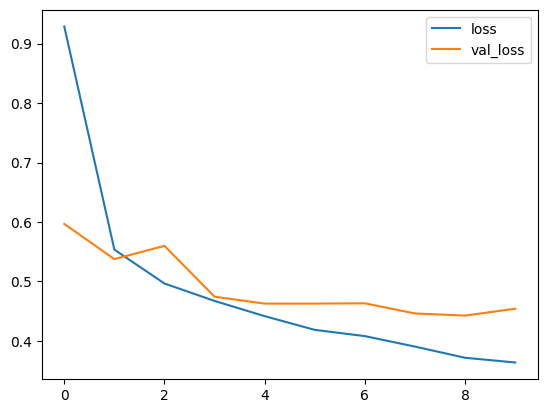

In [113]:
 plt.figure()
 plt.plot(range(N_EPOCHS), h.history['loss'], label='loss')
 plt.plot(range(N_EPOCHS), h.history['val_loss'], label='val_loss')
 plt.legend()
 plt.show()

Using callbacks to stop training and avoid overfitting


*   Early stopping with a certain patience
*   Save (and load!) best model

*   Concatinate the T1 and T2 works for multimodality 



In [114]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=PATIENCE),
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_FNAME_PATTERN, save_best_only=True)
]

segnet = get_segnet()
segnet.compile(optimizer=OPTIMISER, loss=LOSS)
segnet.fit(
    x=np.concatenate((training_patches_T1, training_patches_T2), axis=-1), 
    y=training_patches_seg,
    validation_data=(np.concatenate((validation_patches_T1, validation_patches_T2), axis=-1), validation_patches_seg),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    callbacks=my_callbacks,
    verbose=1)

Epoch 1/10
213/213 [==============================] - 76s 356ms/step - loss: 2.4731 - val_loss: 0.5447
Epoch 2/10
213/213 [==============================] - 76s 356ms/step - loss: 0.5076 - val_loss: 0.4710
Epoch 3/10
213/213 [==============================] - 78s 367ms/step - loss: 0.4525 - val_loss: 0.4486
Epoch 4/10
213/213 [==============================] - 81s 380ms/step - loss: 0.4224 - val_loss: 0.4270
Epoch 5/10
213/213 [==============================] - 84s 392ms/step - loss: 0.4082 - val_loss: 0.4017
Epoch 6/10
213/213 [==============================] - 81s 379ms/step - loss: 0.3901 - val_loss: 0.4018
Epoch 7/10
213/213 [==============================] - 87s 410ms/step - loss: 0.3715 - val_loss: 0.3717
Epoch 8/10
213/213 [==============================] - 90s 418ms/step - loss: 0.3490 - val_loss: 0.3688
Epoch 9/10
213/213 [==============================] - 83s 388ms/step - loss: 0.3420 - val_loss: 0.3600
Epoch 10/10
213/213 [==============================] - 85s 398ms/step - l

**Load best model**

In [115]:
segnet = get_segnet(
    img_size=(IMAGE_SIZE[1], IMAGE_SIZE[2]),
    n_classes=N_CLASSES,
    n_input_channels=N_INPUT_CHANNELS)

segnet.compile(optimizer=OPTIMISER, loss=LOSS)
segnet.load_weights('model.h5')

**Prepare test data**

In [116]:
testing_volumes_T1_processed = testing_volumes_T1.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
testing_volumes_T2_processed = testing_volumes_T2.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
testing_labels_processed = testing_labels.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2]])

**Predict labels for test data**

5/5 [==============================] - 15s 3s/step


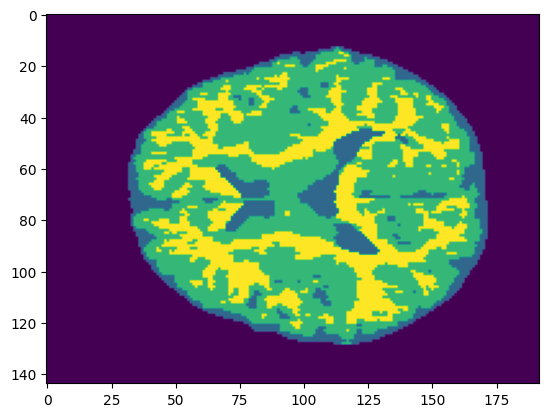

In [117]:
prediction = segnet.predict(x=np.concatenate((testing_volumes_T1_processed, testing_volumes_T2_processed), axis=-1))

prediction = np.argmax(prediction, axis=3)

plt.imshow(prediction[:, :, 150])

In [17]:
!pip install medpy

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 151.8/151.8 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 40.1/40.1 MB 4.4 MB/s eta 0:00:00
     ---------------------------------------- 27.1/27.1 MB 5.1 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.4.0-py3-none-any.whl size=215881 sha256=f4ef32c1b8e9426aa74f331d9ffc959924f6c00ba9dc6f24067010c1022fdb30
  Stored in directory: c:\users\lenovo\appdata\local\pip\cache\wheels\1d\db\31\8b6329aa0414435981be7683b21777565265fa881e8408cf11
Successfully built medpy



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [118]:
import numpy as np
import nibabel as nib
from medpy.metric.binary import dc, hd, ravd

def compute_dice(prediction, reference) :
  for c in np.unique(prediction) :
    dsc_val = dc(prediction == c, reference==c)
    print(f'Dice coefficient class {c} equal to {dsc_val : .2f}')

def compute_hd(prediction, reference, voxel_spacing) :
  for c in np.unique(prediction) :
    hd_val = hd(prediction == c, reference==c, voxelspacing=voxel_spacing, connectivity=1)
    print(f'Hausdorff distance class {c} equal to {hd_val : .2f}')

def compute_ravd(prediction, reference) :
  for c in np.unique(prediction) :
    ravd_val = ravd(prediction == c, reference==c)
    print(f'Dice coefficient class {c} equal to {ravd_val : .2f}')

compute_dice(prediction, testing_labels_processed)
compute_hd(prediction, testing_labels_processed, [1, 1, 1])
compute_ravd(prediction, testing_labels_processed)

Dice coefficient class 0 equal to  1.00
Dice coefficient class 1 equal to  0.89
Dice coefficient class 2 equal to  0.83
Dice coefficient class 3 equal to  0.71
Hausdorff distance class 0 equal to  3.61
Hausdorff distance class 1 equal to  9.49
Hausdorff distance class 2 equal to  8.49
Hausdorff distance class 3 equal to  9.11
Dice coefficient class 0 equal to -0.00
Dice coefficient class 1 equal to -0.01
Dice coefficient class 2 equal to  0.04
Dice coefficient class 3 equal to -0.07
